# Fraud Detection Case Study

In [1]:
import numpy as np
import pandas as pd
from itertools import *
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RFC

from numpy.linalg import svd

import matplotlib.pyplot as plt
%matplotlib inline

import random
import cPickle as pickle


In [3]:
data = pd.read_json('../../data.json')

Singular Value Decomposition (To reduce the number of features) -

https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html



In [4]:
data.head()

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
0,fraudster_event,1266062400,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,...,"[{u'event_id': 527017, u'cost': 25.0, u'availa...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL
1,premium,1296720000,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,...,"[{u'event_id': 786878, u'cost': 35.0, u'availa...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC
2,premium,1296172800,2601,8,US,USD,1.0,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,...,"[{u'event_id': 787337, u'cost': 93.51, u'avail...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA
3,premium,1388966400,12347,6,IE,EUR,1.0,"<p style=""margin-bottom: 1.3em; padding-bottom...",irishtabletennis.com,1360681570,...,"[{u'event_id': 885645, u'cost': 25.0, u'availa...",889,1283870102,3,,None,NaN,NaN,None,None
4,premium,1297900800,2417,11,US,USD,0.0,<p>Writers and filmmakers need to understand t...,artsandbusinesscouncil.org,1291994666,...,"[{u'event_id': 1114349, u'cost': 150.0, u'avai...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA


In [5]:
data['acct_type'].unique()

array([u'fraudster_event', u'premium', u'spammer_warn', u'fraudster',
       u'spammer_limited', u'spammer_noinvite', u'locked', u'tos_lock',
       u'tos_warn', u'fraudster_att', u'spammer_web', u'spammer'], dtype=object)

In [6]:
Counter(data['acct_type'])

Counter({u'fraudster': 437,
         u'fraudster_att': 5,
         u'fraudster_event': 851,
         u'locked': 54,
         u'premium': 12373,
         u'spammer': 1,
         u'spammer_limited': 218,
         u'spammer_noinvite': 84,
         u'spammer_warn': 144,
         u'spammer_web': 2,
         u'tos_lock': 77,
         u'tos_warn': 91})

In [7]:
data[data['acct_type']=='locked']

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
107,locked,1328925600,775,11,US,USD,1.0,"<p style=""text-align: center;""><span style=""fo...",inkfestlive.com,1326313347,...,"[{u'event_id': 2753403, u'cost': 140.76, u'ava...",699,1265909067,3,4551 Old Airport Road,US,35.388063,-80.502267,Cabarrus Arena & Events Center,NC
564,locked,1314820800,1250,8,US,USD,0.0,"<p style=""text-align: center;"">""They say I nev...",launchpadinw.com,1312837914,...,"[{u'event_id': 2015513, u'cost': 39.0, u'avail...",350,1282604097,4,120 N. Stevens,US,47.658673,-117.419462,LaunchPad Training Center and Coworking Space,WA
1149,locked,1337574600,1558,8,AU,AUD,1.0,<p><strong>SITHFAB009A Provide Responsible Ser...,ctq.net.au,1334276309,...,"[{u'event_id': 3344475, u'cost': 69.51, u'avai...",667,1276650716,3,Harney St,AU,-21.157512,149.174817,Mackay Hockey Association,QLD
1308,locked,1376010000,243,0,US,USD,0.0,<p>Reggae Festival August 3rd Gates open at 1 ...,datachieve.com,1360013774,...,"[{u'event_id': 5416446, u'cost': 10.0, u'avail...",958,1277222239,3,14108 St Paul Road,US,39.700398,-77.887713,Knob Hall Winery,MD
1310,locked,1361165400,2337,11,US,USD,0.0,"<p style=""text-align: justify;"">&nbsp;</p>\r\n...",smokinbettys.com,1360184555,...,"[{u'event_id': 5441324, u'cost': 40.0, u'avail...",22,1358275015,1,22 S 23rd St,US,39.953200,-75.178092,23rd Street Armory,PA
1396,locked,1372822200,18475,0,US,USD,1.0,"<p style=""font-size: 12.0pt; mso-bidi-font-siz...",nantucketfilmfestival.org,1367954317,...,"[{u'event_id': 6588205, u'cost': 15.0, u'avail...",76,1361425379,1,10 South Water Street,US,41.284387,-70.098133,The Dreamland - Studio Theater,MA
2169,locked,1369375200,20924,8,US,USD,0.0,"<p style=""color: #03080b; background-color: #f...",themoonbridge.com,1337372587,...,"[{u'event_id': 3575521, u'cost': 100.0, u'avai...",49,1333161879,3,2079 E. 15TH ST.,US,34.030926,-118.238043,MoonPad,CA
3157,locked,1335207600,621,5,US,USD,0.0,"<p><span style=""font-size: large;"">LIL SCRAPPY...",gmail.com,1333481485,...,"[{u'event_id': 3282403, u'cost': 20.0, u'avail...",41,1329951135,1,600 ne colorado st,US,46.734150,-117.170788,stubblefields,WA
3530,locked,1303192800,2595,0,GB,GBP,1.0,"<p class=""MsoNormal"" style=""text-align: left; ...",yellamo.com,1301958989,...,"[{u'event_id': 1524823, u'cost': 36.95, u'avai...",1078,1208817407,3,The Clerkenwell Workshops,GB,51.524266,-0.106894,The Clerkenwell Kitchen,
3659,locked,1337659200,2595,4,US,USD,0.0,"<p><img src=""http://www.eventsinsouthflorida.c...",republicanflorida.com,1335481354,...,"[{u'event_id': 3436349, u'cost': 0.0, u'availa...",101,1326774977,3,1239 EAST LAS OLAS BLVD,US,26.119344,-80.130198,EVOO MARKET,FL


In [8]:
a_loon = {'fraudster': 1, 'fraudster_att': 1, 'fraudster_event': 1, 'locked': 1, 'premium': 0}


In [16]:
df_first = data[(data['acct_type']=='fraudster') | (data['acct_type']=='fraudster_att') | (data['acct_type']=='fraudster_event')
    | (data['acct_type']=='premium')]

In [17]:
y = df_first['acct_type'].map(a_loon)

In [18]:
df_first.columns

Index([u'acct_type', u'approx_payout_date', u'body_length', u'channels',
       u'country', u'currency', u'delivery_method', u'description',
       u'email_domain', u'event_created', u'event_end', u'event_published',
       u'event_start', u'fb_published', u'gts', u'has_analytics',
       u'has_header', u'has_logo', u'listed', u'name', u'name_length',
       u'num_order', u'num_payouts', u'object_id', u'org_desc',
       u'org_facebook', u'org_name', u'org_twitter', u'payee_name',
       u'payout_type', u'previous_payouts', u'sale_duration',
       u'sale_duration2', u'show_map', u'ticket_types', u'user_age',
       u'user_created', u'user_type', u'venue_address', u'venue_country',
       u'venue_latitude', u'venue_longitude', u'venue_name', u'venue_state'],
      dtype='object')

In [24]:
df_first[(df_first['fb_published'] == 1) & (df_first['acct_type'] == 'premium') ]

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
4,premium,1297900800,2417,11,US,USD,0.0,<p>Writers and filmmakers need to understand t...,artsandbusinesscouncil.org,1291994666,...,"[{u'event_id': 1114349, u'cost': 150.0, u'avai...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA
8,premium,1298185200,4388,4,US,USD,0.0,"<p style=""text-align: center;""><font face=""boo...",credosf.com,1294428122,...,"[{u'event_id': 1180423, u'cost': 250.0, u'avai...",0,1294428121,3,465 California Street,US,37.792847,-122.402082,,
14,premium,1300942800,10057,11,US,USD,0.0,"<p class=""MsoNormal"" style=""text-align: center...",simplystylist.com,1296069679,...,"[{u'event_id': 1245809, u'cost': 150.0, u'avai...",197,1279046075,3,1650 Schrader Boulevard,US,34.100945,-118.332378,Eden Lounge,CA
18,premium,1313881200,3387,11,US,USD,1.0,"<h3 style=""text-align: center;"">Rob Holmes is ...",ipcybercrime.com,1297481644,...,"[{u'event_id': 1310849, u'cost': 474.08, u'ava...",709,1236178830,4,10720 Cambie Rd.,CA,49.184581,-123.106135,,
20,premium,1302328800,3530,6,FR,EUR,1.0,"<p><font size=""2"">Since its inception ÉCU- The...",ecufilmfestival.com,1297681049,...,"[{u'event_id': 1311215, u'cost': 150.0, u'avai...",2,1297501981,3,"98, bd du Montparnasse",FR,48.842580,2.327782,,
25,premium,1303434000,3254,8,US,USD,1.0,"<p><font face=""Arial"" size=""2"" color=""#ff0000""...",yahoo.com,1299010553,...,"[{u'event_id': 1377131, u'cost': 50.0, u'avail...",536,1252729123,3,550 Bunker Lake Boulevard NW,US,45.217238,-93.278722,Bunker Park Stables,MN
28,premium,1309474800,1083,11,US,USD,1.0,<p>Come and Join the #1 Botox and Dermal Fille...,facialesthetics.org,1300289273,...,"[{u'event_id': 1442185, u'cost': 3702.3, u'ava...",245,1279136852,4,1750 West Loop South,US,29.748834,-95.456646,Houston Marriott West Loop by The Galleria,TX
30,premium,1305018000,326,0,US,USD,1.0,"<p><strong><font size=""5"" color=""#ff0000""><spa...",gmail.com,1301534812,...,"[{u'event_id': 1507635, u'cost': 32.08, u'avai...",608,1248965259,4,807 East Main Street #350,US,35.990016,-78.891405,The Cottonroom Durham,NC
40,premium,1312398000,3164,8,US,USD,3.0,"<p><font face=""impact,chicago"" size=""3"">The Li...",sbcglobal.net,1305754607,...,"[{u'event_id': 1704255, u'cost': 0.0, u'availa...",0,1305754603,3,6245 Sylvan Dr,US,34.262454,-118.668675,The Live Ride Christian Church,CA
45,premium,1313038800,4179,11,US,USD,0.0,"<p>Food, fun, and fashion all for a good cause...",aol.com,1307323140,...,"[{u'event_id': 1770371, u'cost': 17.91, u'avai...",318,1279859186,1,1216 Sunbury Rd,US,39.993626,-82.939708,Ohio Dominican University,OH


In [28]:
df_first['regi_use_time_delta'] = df_first['event_created'] - df_first['user_created']

/home/sanhita/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [30]:
df_first[['regi_use_time_delta', 'acct_type']]

,regi_use_time_delta,acct_type
0,3125756,fraudster_event
1,12889894,premium
2,18531568,premium
3,76811468,premium
4,3010601,premium
5,25842700,premium
6,60987067,premium
7,6151734,premium
8,1,premium
9,6152183,premium


In [32]:
df_first[df_first['acct_type'].str.contains('fraud')]['regi_use_time_delta'].mean()

7528982.6055684453

In [33]:
df_first[df_first['acct_type'].str.contains('premium')]['regi_use_time_delta'].mean()

34292148.041461244

In [37]:
col = 'show_map'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

0.756380510441

0.850804170370969

In [38]:
col = 'fb_published'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

0.0224284609435

0.13569869877960075

In [39]:
col = 'has_logo'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

0.645784996133

0.86106845550796085

In [40]:
col = 'has_header'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

0.0693641618497

0.21320754716981133

In [43]:
col = 'org_facebook'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

1.03554119548

8.60037189748565

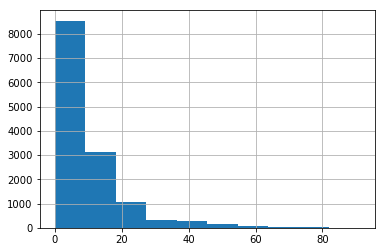

In [45]:
df_first['org_facebook'].hist()

In [56]:
col = 'listed'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

TypeError: Could not convert ynyynnyyyynyyyyyynyyyyyyyyyyyyyyynnyynyyyyyyyyyyyyyyyyyyyyyyynyyyyyynyyyyyyynnynyynyynnnyyyyyyyyyyyyyyynyyyyyyyyynyyyyyynnyyyyyyyyyyyyyyynnyynynyyyynynyyyyynnyynyyyyyyyyyyyynyyyyyyyyynyynnyynnyynyyyyyyyyyyyyyyyyyyyyyynynnynyyynyyyyynyynynyyynyyyyyynyyyynyyyyyyyyyyyyyyyyyynyyyyynyyyyyyyynynyyyyyyyyyynyyyyyyyyyynnyynyynyyynynnyyyyyyynnyyyyyyyyyynyyynnnyyyyyyyyyyynyyyyyyyyyyynyyyyyyynyynyyyyyyyyyyyyyyyynyyyyyynnyynnyyyyynyyyyyyynnnyynyyyyyyyyyyyyyyyynnyynyyyyyyynyyynyyyyyyyyyynyyyyyynyyyyyyyyyynnyynyynnynnyyyyyynyyyyyyynyyyyyyyyyyyyynyyyyyyyyyyynnyyyynyyyyyyyyyynyyyyyyyyyyyyyyyyyyyyyyyyyyyynnnnyyyyyyyyyyyyynyyynnyyyyyyyyyyyyyyyyyynyynyyyyyyyyyynyyyyyynyyyyyyyyyyyynyyyyyynynyyyyyynyyynyynyyyyyyynyyynyyyyyynyyyyyynyyyyyyynyyyyyyyyyyyyyynyyynyyyyyyyyynyyyyyyyyyyyyyynnyyyyynyynyynyynyyynyyynnnnnyyyyynyyyyynyynyyyyyyyyyyynyyyyyyyyyyyynyyyyynnnyynyyyyyyyynnyyyyyyynyyyyyyyyynyyynyynyyyyyyyyynyyyynnyyyyyyyyyyyyyyyyyyyyynyyynyynyyyyyyyyyyyyyynnyyyyyyyyyynyyyyyyyyynyyynyyyyyyynyynyyyyyyyyyyyyyyynyynyyyyyyyynynynnyyyyyyyyynyyyyyyyyyynyyyyyyynyyyyyyyyyynnynnyyynnynyyyyyyyyynyyyyyyyynyyyyyyyynynyyyyynnnynyyyyyyynnyynyyyyyyyyyyyyyyyyyyyyyyyyyyyynyyyyyynnyyyyyyyyyyyyyyyyyyyynnyyynyyyyyyyyyyyyynyynyyyyynyyyynnyyyynyyyyyyyyyyyynynyyyyynynyyyyyyyyyyynyyyyyyyyyyyyyynyyyyyyyyyyynyyyyyyynyyyynnnn to numeric